# Count Model Regression Exercises

In [32]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

In [33]:
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

# Exercise 1: Transformation and Model Intuition [Easy]

Messing up the order of non linear transformations can lead to wrong answers all too easily. I know because I did this during writing this.

In this exercise were going to work through transformations outside of a model to ensure the difference is clear. we then are going to run a parameter recovery study, implementing models in both PyMC and Bambi to ensure we have an end to end understanding of everything that is going on.

## 1a: Show that the for a random vector show that `np.exp(mean(x)) != mean(np.exp))`

In [34]:
x = np.random.normal(size=1000)

In [35]:
x_mean = np.mean(x)

y = np.exp(x)

print("Calculation 1", np.exp(x_mean))
print("Calculation 2", np.mean(y))

Calculation 1 1.0049158917641203
Calculation 2 1.694453641004559


In [36]:
x = np.random.normal(size=1000)
y = 2

In [37]:
print("Calculation 1", np.exp(x + y).mean())
print("Calculation 2", (np.exp(x) + 2).mean())

Calculation 1 12.187695389784007
Calculation 2 3.6494252075779774


## 1b: Build a Poisson model in PyMC with to estimate our known parameters

We;re going to do a parameter recovery and prediction verification. Doing this end to end will ensure you're getting every step correct, and especially the transformation steps above correct as it can be easy or tempting to make a mistake.

Specifically we want two things an az.summary table showing the estimated parameters, which we than can compare with the fixed parameters we used for data generation

In [38]:
# Parameters to recover
intercept = 0.3
slope = 0.7
categorical_effect = 0.5

# Random Observations. We create many so out sampler has the best chance of recovering the final value
x = stats.uniform(-1, 1).rvs(22345)
categorical_indicator = stats.bernoulli(p=0.7).rvs(22345)

# Data Generating Process
mu = slope * x + categorical_indicator * categorical_effect + intercept
lamda = np.exp(mu)
y = stats.poisson(lamda).rvs()

In [39]:
data = pd.DataFrame({"x": x, "categorical": categorical_indicator, "y": y})
data["categorical"] = pd.Categorical(data["categorical"])
data.head()

,x,categorical,y
0,-0.580031,0,0
1,-0.211846,1,0
2,-0.060105,1,1
3,-0.569067,1,0
4,-0.755286,0,2


With the data loaded let's write a PyMC model that takes into account the X input, the categorical indicator, and includes an intercept as well.

In [40]:
with pm.Model() as model:
    slope_var = pm.Normal("slope", 0, 50)
    intercept_var = pm.Normal("intercept", 0, 50)
    categorical_effect_var = pm.Normal("categorical", 0, 50)

    μ = intercept_var + slope_var * x + categorical_effect_var * categorical_indicator
    λ = np.exp(μ)

    rooms = pm.Poisson("y", λ, observed=y)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, categorical]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


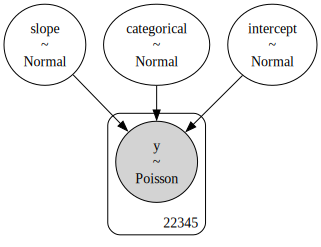

In [41]:
pm.model_to_graphviz(model)

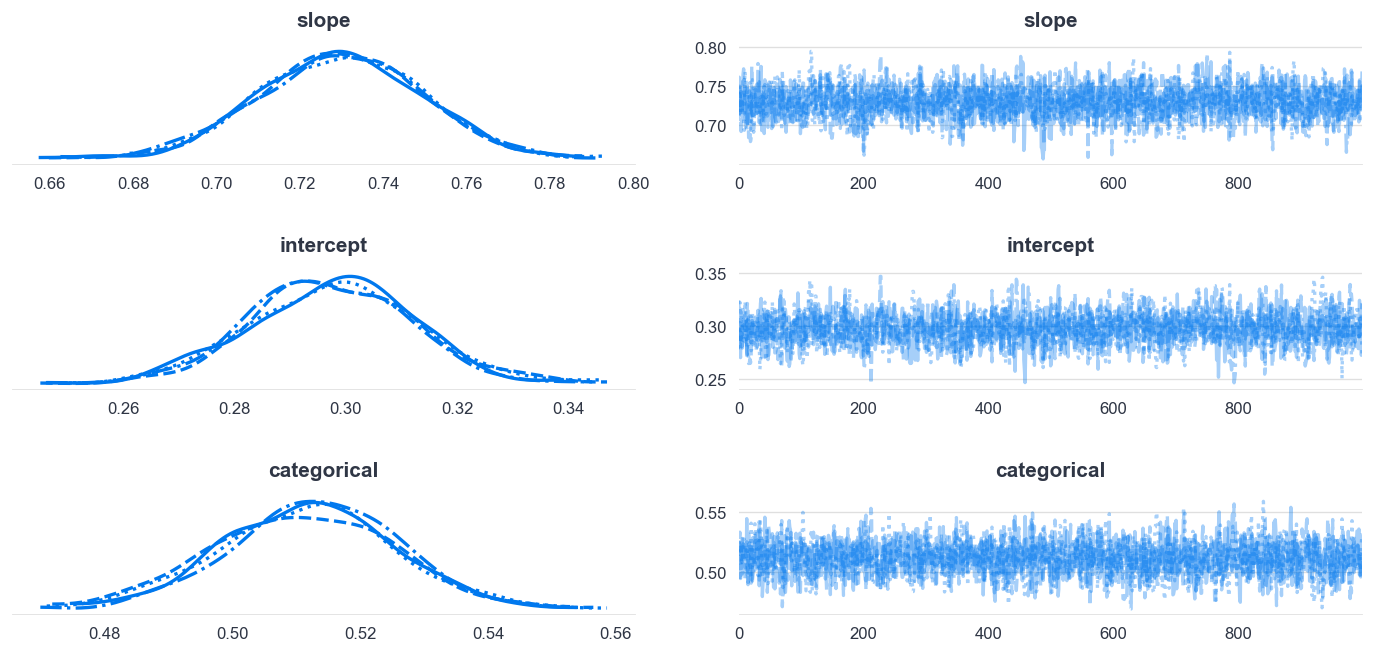

In [42]:
az.plot_trace(idata);

In [43]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.730,0.019,0.694,0.766,0.0,0.0,1956.0,1908.0,1.0
intercept,0.298,0.015,0.269,0.324,0.0,0.0,1497.0,1588.0,1.0
categorical,0.512,0.014,0.485,0.536,0.0,0.0,1854.0,1716.0,1.0


Great! We got a model that largely estimates the input parameters.

## 1c: Build a Poisson model in PyMC with to estimate our known parameters
Let's now do the same with Bambi to see what we get.

In [ ]:
# Build your bambi model here

In [44]:
model = bmb.Model("y ~ x + categorical", family="poisson", data=data)
model.build()
model

       Formula: y ~ x + categorical
        Family: poisson
          Link: mu = log
  Observations: 22345
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 6.2748)
            x ~ Normal(mu: 0.0, sigma: 8.6575)
            categorical ~ Normal(mu: 0.0, sigma: 5.4491)

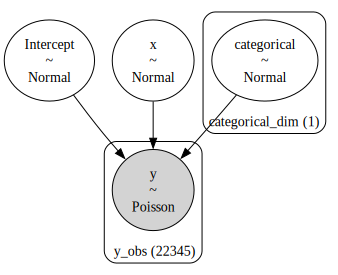

In [45]:
model.graph()

In [46]:
idata_bmb = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, categorical]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [47]:
az.summary(idata_bmb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.298,0.015,0.269,0.327,0.0,0.0,5172.0,2950.0,1.0
x,0.729,0.020,0.695,0.768,0.0,0.0,5618.0,3204.0,1.0
categorical[1],0.512,0.014,0.484,0.538,0.0,0.0,4897.0,3081.0,1.0


After inference we get results similar to the PyMC model. As expected Bambi automatically adds the intercept detects the categorical variable correctly. estimating the "1" level.

## 1d: Estimate the Poisson distribution at a fixed inputs value "by hand", with Bambi and with posterior samples
We'll used the fixed values, where x is set a particular float value, and we include the categorical effect as well

You'll need to do three things here
* Simulate the expected Poisson distributions at fixed values of x and categorical indicators by hand
* Use PyMC posterior predictive functionality to show what the same estimate would be
* Use the Bambi predict functionality to generate a posterior predictive to show what the same estimate would be

The output were looking for is three plots, one that shows "true" Poisson distribution, one showing the PyMC estimate, and one showing the Bambi estimate

In [48]:
# Here we provide the values for you
x_new = 5
categorical_indicator_new = 1
data_new = pd.DataFrame({"x": [x_new], "categorical": [categorical_indicator_new]})
data_new["categorical"] = pd.Categorical(data_new["categorical"])

data_new

,x,categorical
0,5,1


In [49]:
# Simulate the data manually
mu = slope * x_new + categorical_indicator_new * categorical_effect + intercept
_lambda = np.exp(mu)
y_manual = stats.poisson(_lambda).rvs(20000)

Calculate mu and lambda here. These are our "true deterministics" that we will be estimating later with PyMC and bambi. After getting. those plot the observed distribution of y_manual as well.

In [50]:
mu, _lambda, y_manual.mean()

(4.3, 73.69979369959579, 73.5905)

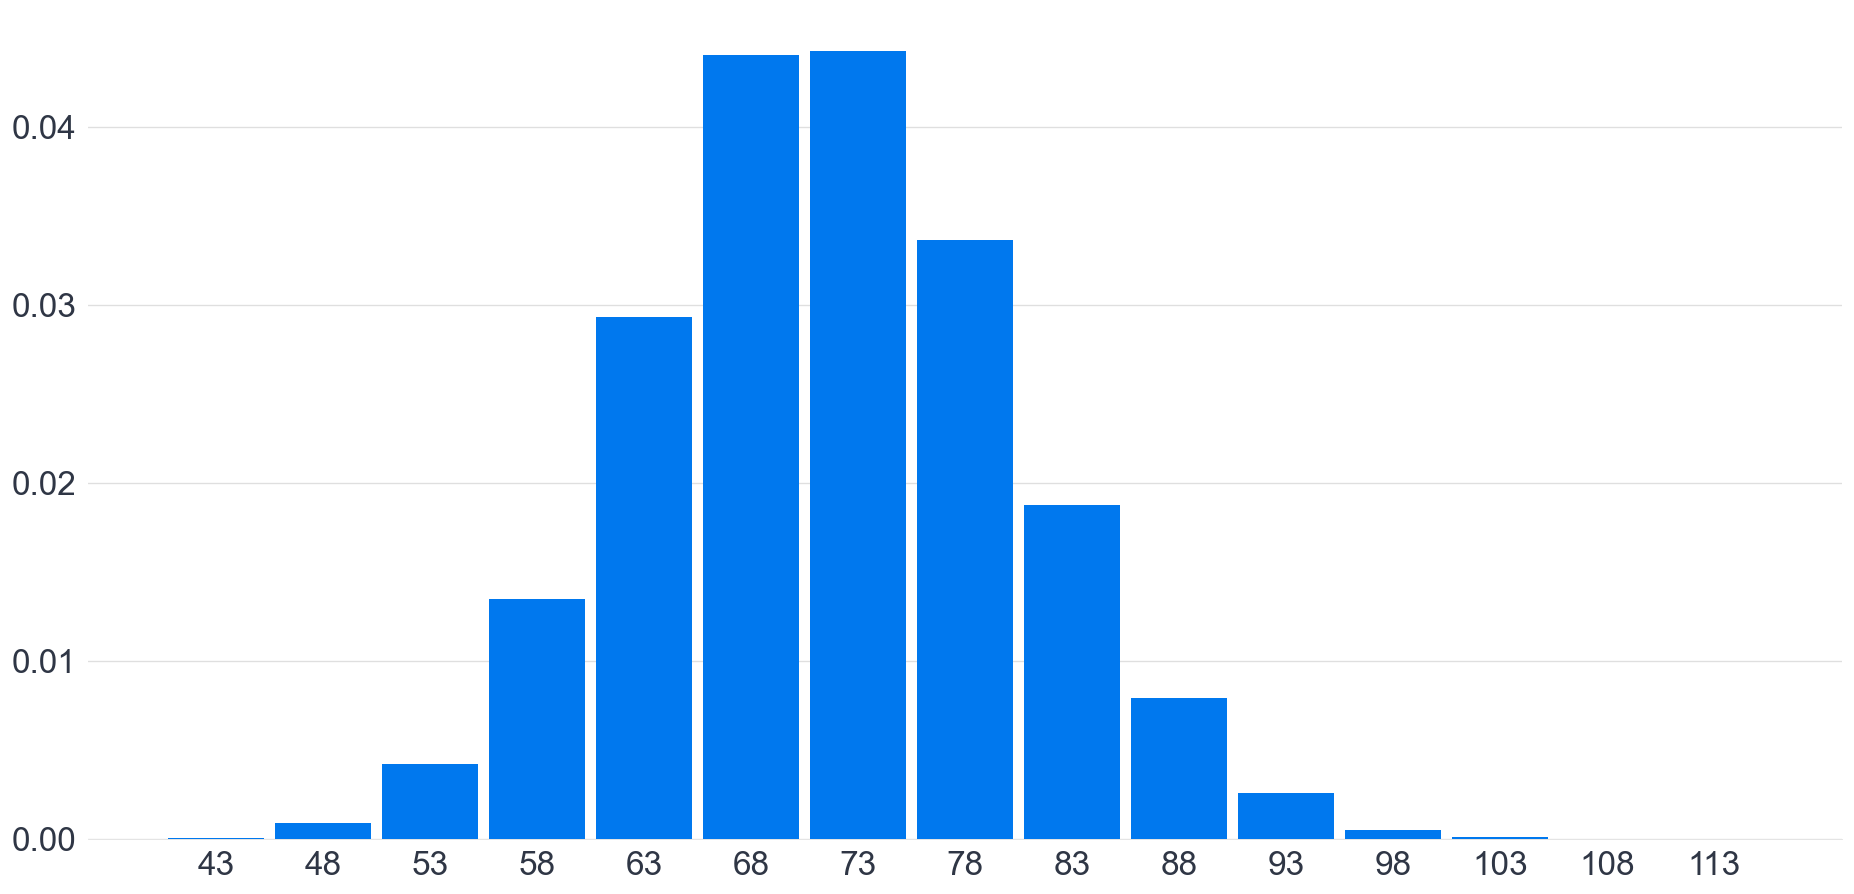

In [51]:
az.plot_dist(y_manual);

This is our "true" expected Poisson distribution from the data generating process. 
Let's now estimate our expected Try using `az.summary`, then try from the samples directly`

In [52]:
summary = az.summary(idata_bmb)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.298,0.015,0.269,0.327,0.0,0.0,5172.0,2950.0,1.0
x,0.729,0.020,0.695,0.768,0.0,0.0,5618.0,3204.0,1.0
categorical[1],0.512,0.014,0.484,0.538,0.0,0.0,4897.0,3081.0,1.0


In [53]:
# Take the summary directly. This is wrong.
mu_new_mean = (
    summary.loc["x", "mean"] * x_new
    + summary.loc["categorical[1]", "mean"] * categorical_indicator_new
    + summary.loc["Intercept", "mean"]
)

lambda_new_mean = np.exp(mu_new_mean)
mu_new_mean, lambda_new_mean

(4.455, 86.05615084513838)

In [54]:
# Get the samples 
slope_estimate = idata_bmb.posterior["x"].to_numpy().reshape(-1)
categorical_estimate = idata_bmb.posterior["categorical"].to_numpy().reshape(-1)
intercept_estimate = idata_bmb.posterior["Intercept"].to_numpy().reshape(-1)

In [55]:
# Mean, Addition, Transform: This is also wrong
MU_new_mean = (
    slope_estimate.mean() * x_new
    + categorical_estimate.mean() * categorical_indicator_new
    + intercept_estimate.mean()
)

MU_new_mean, np.exp(MU_new_mean)

(4.456453235027818, 86.18130157259078)

In [56]:
# Vector Add, Transform, Mean: This should be right
mu_new = (
    slope_estimate * x_new
    + categorical_estimate * categorical_indicator_new
    + intercept_estimate
)

lambda_new = np.exp(mu_new)
mu_new.mean(), lambda_new.mean()

(4.456453235027818, 86.6766726716244)

Let's now estimate the same using Bambi's predict functionality.  We wont inspect the samples for the parameters again as part of this exercise, though you can do so yourself to verify they match the samples from PyMC.

In [57]:
new_predictions = model.predict(
    idata_bmb,
    kind="pps",
    data=data_new,
    inplace=False,
)

new_predictions

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [61]:
new_predictions.posterior_predictive["y"].mean()

<xarray.DataArray 'y' ()>
array(86.64975)

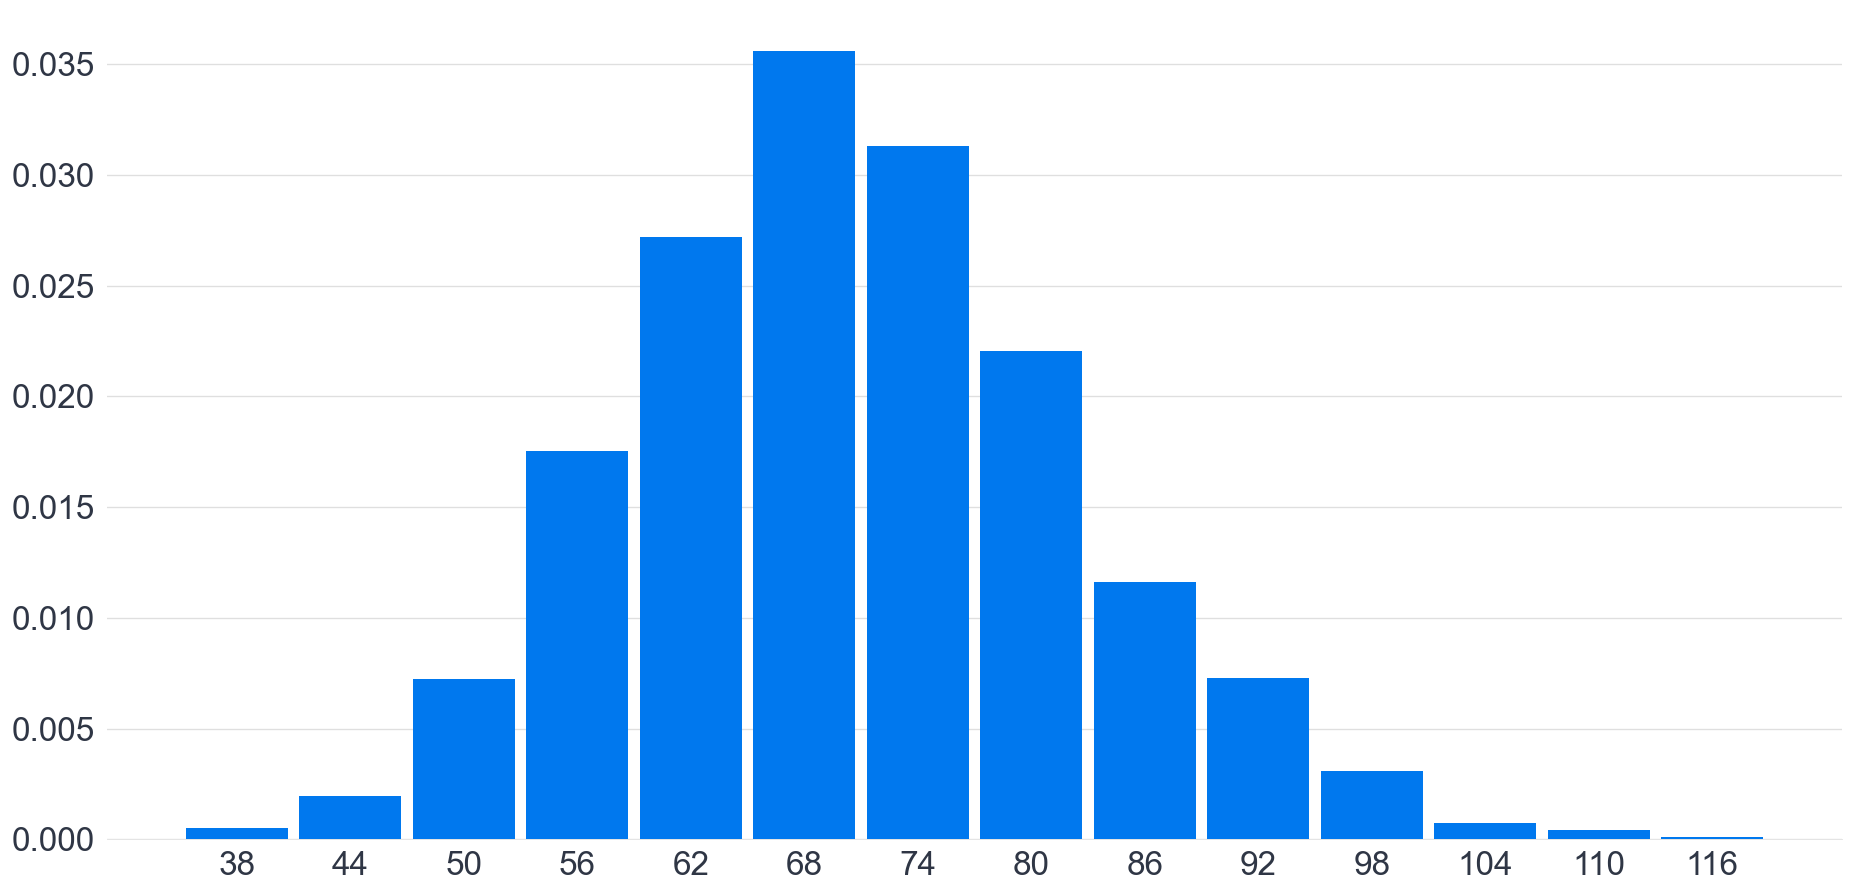

In [28]:
az.plot_dist(new_predictions.posterior_predictive["y"].values.reshape(-1));

# Exercise 2: More football analytics
We're going to reanalyze the football data. We've already looked at the data a couple of ways but perhaps there's more. Let's load the data first before we move onto the questions.

In [29]:
df = pd.read_csv("data/season-1718_csv.csv")
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,11/08/17,Arsenal,Leicester,4,3,H,2,2,D,...,2.32,21,-1.00,1.91,1.85,2.10,2.02,1.49,4.73,7.25
1,E0,12/08/17,Brighton,Man City,0,2,A,0,0,D,...,2.27,20,1.50,1.95,1.91,2.01,1.96,11.75,6.15,1.29
2,E0,12/08/17,Chelsea,Burnley,2,3,A,0,3,A,...,2.23,20,-1.75,2.03,1.97,1.95,1.90,1.33,5.40,12.25
3,E0,12/08/17,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,1.72,18,-0.75,2.10,2.05,1.86,1.83,1.79,3.56,5.51
4,E0,12/08/17,Everton,Stoke,1,0,H,1,0,H,...,1.76,19,-0.75,1.94,1.90,2.01,1.98,1.82,3.49,5.42


In [30]:
df.rename({"FTHG": "GoalsHome", "FTAG": "GoalsAway"}, axis=1, inplace=True)

# Get
df["Date"] = pd.to_datetime(df["Date"])
first_game = df["Date"].min()
df["Days_Since_First_Game"] = (df["Date"] - first_game).dt.days

df = df.iloc[:, [2, 3, 4, 5, -1]]

In [31]:
home_goals = (
    df[["HomeTeam", "GoalsHome", "Days_Since_First_Game"]]
    .assign(GameType="Home")
    .rename({"HomeTeam": "Team", "GoalsHome": "Goals"}, axis=1)
)
away_goals = (
    df[["AwayTeam", "GoalsAway", "Days_Since_First_Game"]]
    .assign(GameType="Away")
    .rename({"AwayTeam": "Team", "GoalsAway": "Goals"}, axis=1)
)

long_df = pd.concat([home_goals, away_goals], axis=0)
long_df.head()

,Team,Goals,Days_Since_First_Game,GameType
0,Arsenal,4,302,Home
1,Brighton,0,332,Home
2,Chelsea,2,332,Home
3,Crystal Palace,0,332,Home
4,Everton,1,332,Home


## 2a: Revisiting home versus away effect
Look back at Premiere League data. Let's answer the following questions.
* Did we use a shared parameter for the effect for all teams when estimating the home and away effect?
* Was the estimated effect the same size for all teams?

This exercise does not require any code, just referencing the lesson and thinking through the answer

**Write your answer here**

**Answer**: 
This is a bit of a trick question. 
We do use a shared parameter for all teams. That's easiest seen using the model graph functionality from Bambi. You can see Team_dim (20) but GameType is 1, indicating one parameter.
However the estimated effect is not the same. That's because once we transform the sum of the individual team effect and the shared goal effect, the difference in the number of goals from home and away is different in the "observed goal" space.ßß

## 2b: Estimating a home vs away effect per team
Let's now ask another question. Does team performance drop over the a season? Let's first create a mode for Man City, and then create one for all teams. For this model we want a `Days_Since_First_Game` effect per team and an intercept per team.

First start with Manchester City and estimate the slope and intercept for that first. Check for converge and parameter estimations there first.
Then expand this to all teams. Use Bambi for both models.

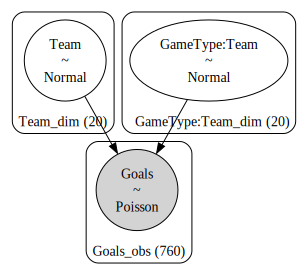

In [32]:
# Load the dataset below
goals_model_bambi = bmb.Model(
    "Goals ~ Team + GameType:Team + 0", long_df, family="poisson"
)
goals_model_bambi.build()
goals_model_bambi.graph()

In [33]:
goals_model_bambi_data = goals_model_bambi.fit()
az.summary(goals_model_bambi_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Team, GameType:Team]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Team[Arsenal],0.027,0.224,-0.408,0.428,0.003,0.004,6547.0,3153.0,1.0
Team[Bournemouth],-0.025,0.233,-0.433,0.423,0.003,0.004,6990.0,2855.0,1.0
Team[Brighton],-0.686,0.328,-1.314,-0.067,0.004,0.003,6743.0,2826.0,1.0
Team[Burnley],0.022,0.231,-0.419,0.431,0.003,0.004,7243.0,3135.0,1.0
Team[Chelsea],0.504,0.176,0.168,0.828,0.002,0.002,6127.0,2533.0,1.0
Team[Crystal Palace],-0.203,0.263,-0.725,0.266,0.003,0.003,6960.0,3109.0,1.0
Team[Everton],-0.205,0.254,-0.676,0.258,0.003,0.003,6354.0,3105.0,1.0
Team[Huddersfield],-0.498,0.295,-1.056,0.049,0.004,0.004,5337.0,2775.0,1.0
Team[Leicester],0.469,0.186,0.120,0.815,0.002,0.002,6164.0,3419.0,1.0
Team[Liverpool],0.708,0.160,0.422,1.020,0.002,0.002,5470.0,2844.0,1.0


In [34]:
mancity_model = bmb.Model(
    "Goals ~ Days_Since_First_Game",
    long_df.query(f"Team == 'Man City'"),
    family="poisson",
)
mancity_idata = mancity_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Days_Since_First_Game]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 513 divergences after tuning. Increase `target_accept` or reparameterize.


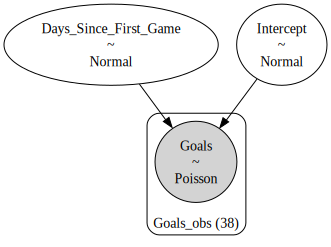

In [35]:
mancity_model.graph()

## 2c: All teams
Now try estimating the `Days_Since_First_Game` for all teams. Use Bambi. Do you run into any issues? If you do think about the scale of days since first game. Anything there that might cause issues?

In [36]:
# Insert Bambi Model here

In [37]:
all_teams_model = bmb.Model(
    "Goals ~ Days_Since_First_Game:Team + Team + 0", long_df, family="poisson"
)
all_teams_idata = all_teams_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Days_Since_First_Game:Team, Team]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


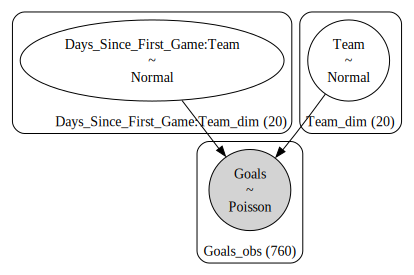

In [38]:
all_teams_model.graph()

In [39]:
az.summary(all_teams_idata)

/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Days_Since_First_Game:Team[Arsenal],-0.348,0.405,-0.898,0.185,0.202,0.154,4.0,4.0,inf
Days_Since_First_Game:Team[Bournemouth],-0.447,0.405,-0.852,0.226,0.202,0.154,4.0,4.0,inf
Days_Since_First_Game:Team[Brighton],0.003,0.452,-0.777,0.323,0.225,0.173,4.0,4.0,inf
Days_Since_First_Game:Team[Burnley],-0.130,0.399,-0.612,0.288,0.199,0.152,4.0,4.0,inf
Days_Since_First_Game:Team[Chelsea],0.027,0.544,-0.908,0.401,0.271,0.208,4.0,4.0,inf
Days_Since_First_Game:Team[Crystal Palace],0.194,0.169,-0.038,0.430,0.084,0.064,4.0,4.0,inf
Days_Since_First_Game:Team[Everton],-0.287,0.112,-0.481,-0.217,0.056,0.043,4.0,4.0,inf
Days_Since_First_Game:Team[Huddersfield],0.047,0.531,-0.862,0.413,0.264,0.202,4.0,4.0,inf
Days_Since_First_Game:Team[Leicester],-0.183,0.474,-0.886,0.429,0.236,0.181,4.0,4.0,inf
Days_Since_First_Game:Team[Liverpool],0.257,0.198,-0.072,0.413,0.099,0.075,4.0,4.0,inf


Convergence failed in our last model. This is especically suspicious because the Manchester City model worked, even though it had an identical structure. The issue is numerical overflow because our `Days_Since_First_Game` is so large. We need to scale our value. We could do this manually but instead we decide to use Bambi built in scaling as  

In [40]:
all_teams_scaled_model = bmb.Model(
    "Goals ~ scale(Days_Since_First_Game):Team + Team + 0", long_df, family="poisson"
)
all_teams_scaled_idata = all_teams_scaled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scale(Days_Since_First_Game):Team, Team]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [41]:
az.summary(all_teams_scaled_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
scale(Days_Since_First_Game):Team[Arsenal],0.103,0.104,-0.091,0.299,0.001,0.001,8881.0,3452.0,1.0
scale(Days_Since_First_Game):Team[Bournemouth],0.106,0.158,-0.200,0.394,0.002,0.002,8147.0,3290.0,1.0
scale(Days_Since_First_Game):Team[Brighton],0.056,0.164,-0.257,0.357,0.002,0.003,9565.0,2722.0,1.0
scale(Days_Since_First_Game):Team[Burnley],0.203,0.166,-0.087,0.536,0.002,0.002,8823.0,2903.0,1.0
scale(Days_Since_First_Game):Team[Chelsea],-0.067,0.121,-0.290,0.170,0.001,0.002,9615.0,2374.0,1.0
scale(Days_Since_First_Game):Team[Crystal Palace],0.411,0.160,0.119,0.715,0.002,0.002,6225.0,2996.0,1.0
scale(Days_Since_First_Game):Team[Everton],0.085,0.153,-0.190,0.379,0.002,0.002,8165.0,2782.0,1.0
scale(Days_Since_First_Game):Team[Huddersfield],0.177,0.198,-0.199,0.527,0.002,0.002,8460.0,3389.0,1.0
scale(Days_Since_First_Game):Team[Leicester],0.090,0.137,-0.158,0.350,0.001,0.002,8456.0,2925.0,1.0
scale(Days_Since_First_Game):Team[Liverpool],-0.104,0.102,-0.293,0.087,0.001,0.001,7718.0,2910.0,1.0


We can now use a forest plot to see this effective. For some teams it does seem plausible that the performance changed over time. However for most teaems it does not seem this is the case.

/home/canyon/miniconda3/envs/ib_advanced_regression/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


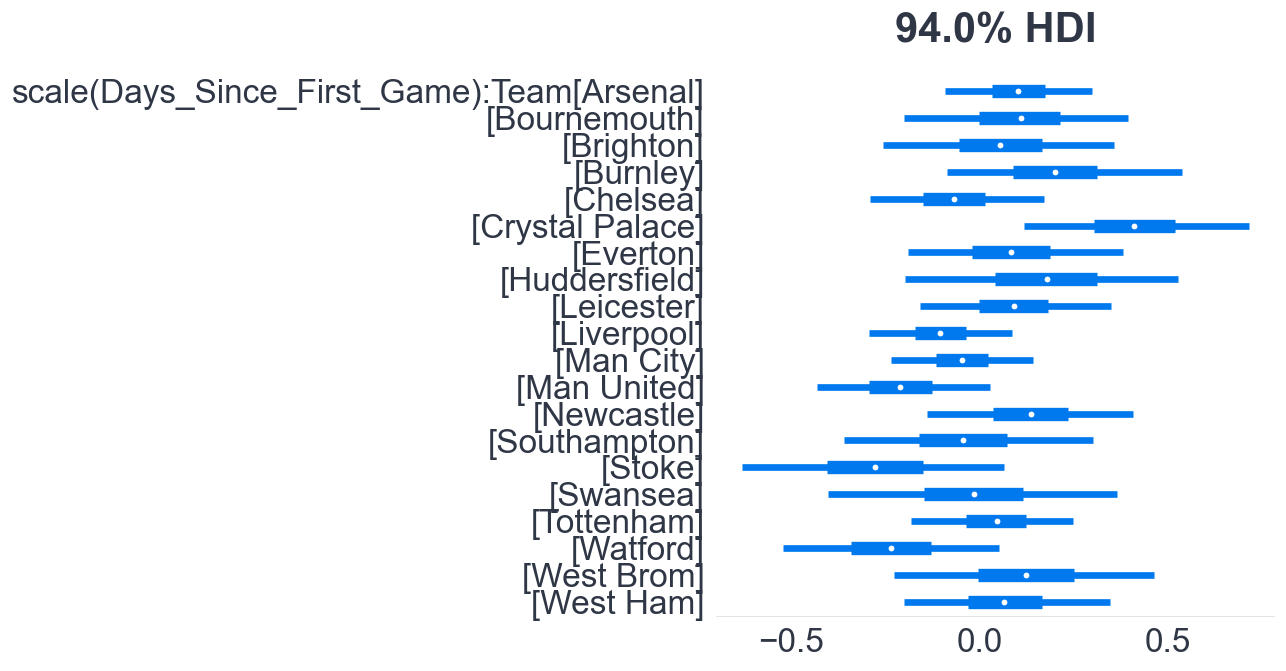

In [42]:
az.plot_forest(all_teams_scaled_idata, var_names ="scale(Days_Since_First_Game)", filter_vars="like", combined=True);

# Exercise 3: Rewriting the fishing model [Hard]
We're going to extend the fishing data. Let's start by loading in the data again.

In [43]:
fish_data = pd.read_stata(
    "data/fish.dta",
    columns=["count", "livebait", "camper", "persons", "child"],
)

fish_data["livebait"] = pd.Categorical(fish_data["livebait"])
fish_data["camper"] = pd.Categorical(fish_data["camper"])
fish_data

,count,livebait,camper,persons,child
0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,2.0,1.0
4,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...
245,0.0,1.0,1.0,2.0,0.0
246,0.0,1.0,1.0,4.0,3.0
247,0.0,1.0,1.0,2.0,1.0
248,0.0,1.0,1.0,3.0,2.0


## 3a Bambi scaled

Write this model again in Bambi, but this time standardizing the persons column (explain why that would even make sense to standardize that column). Think about why it makes sense to scale this for the purposes 


*Why would you want to scale, write your answer here*

Because a group of 0 person doesn't mean anything, so the intercept doesn't mean anything. 0 people catch zero fish. But when we standardize the persons column, the intercept becomes the average number of caught fish, for a group with mean number of persons, 0 children, and 0 whatever the other predictors are.

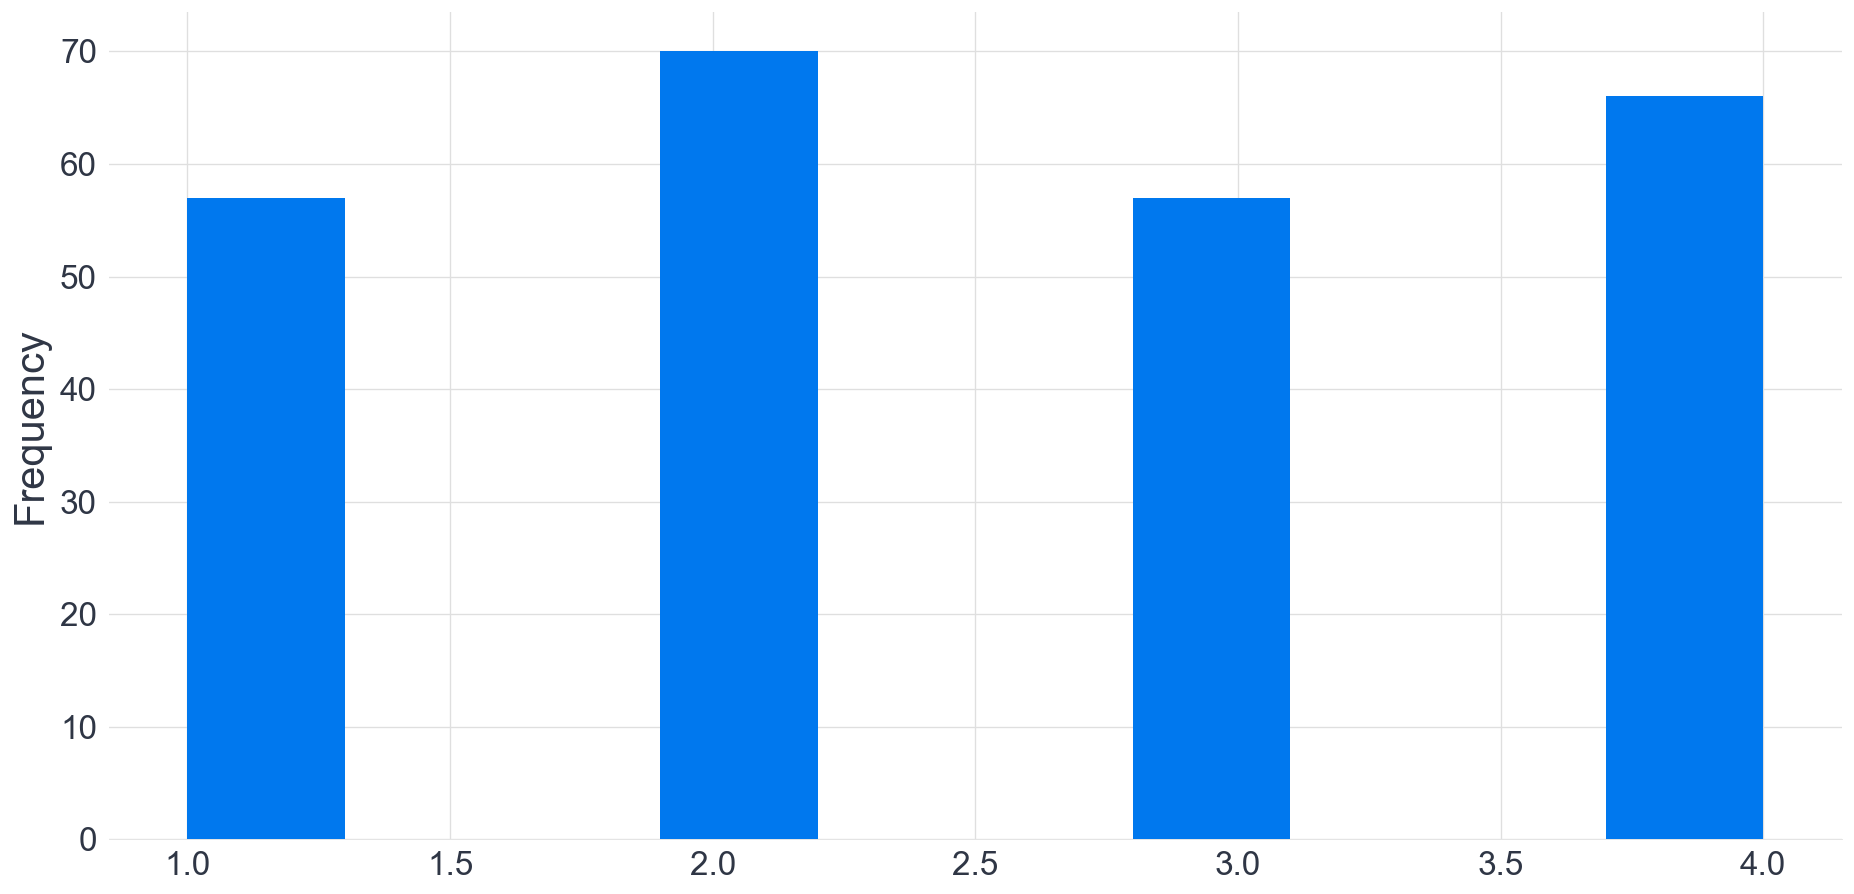

In [44]:
fish_data["persons"].plot(kind="hist");

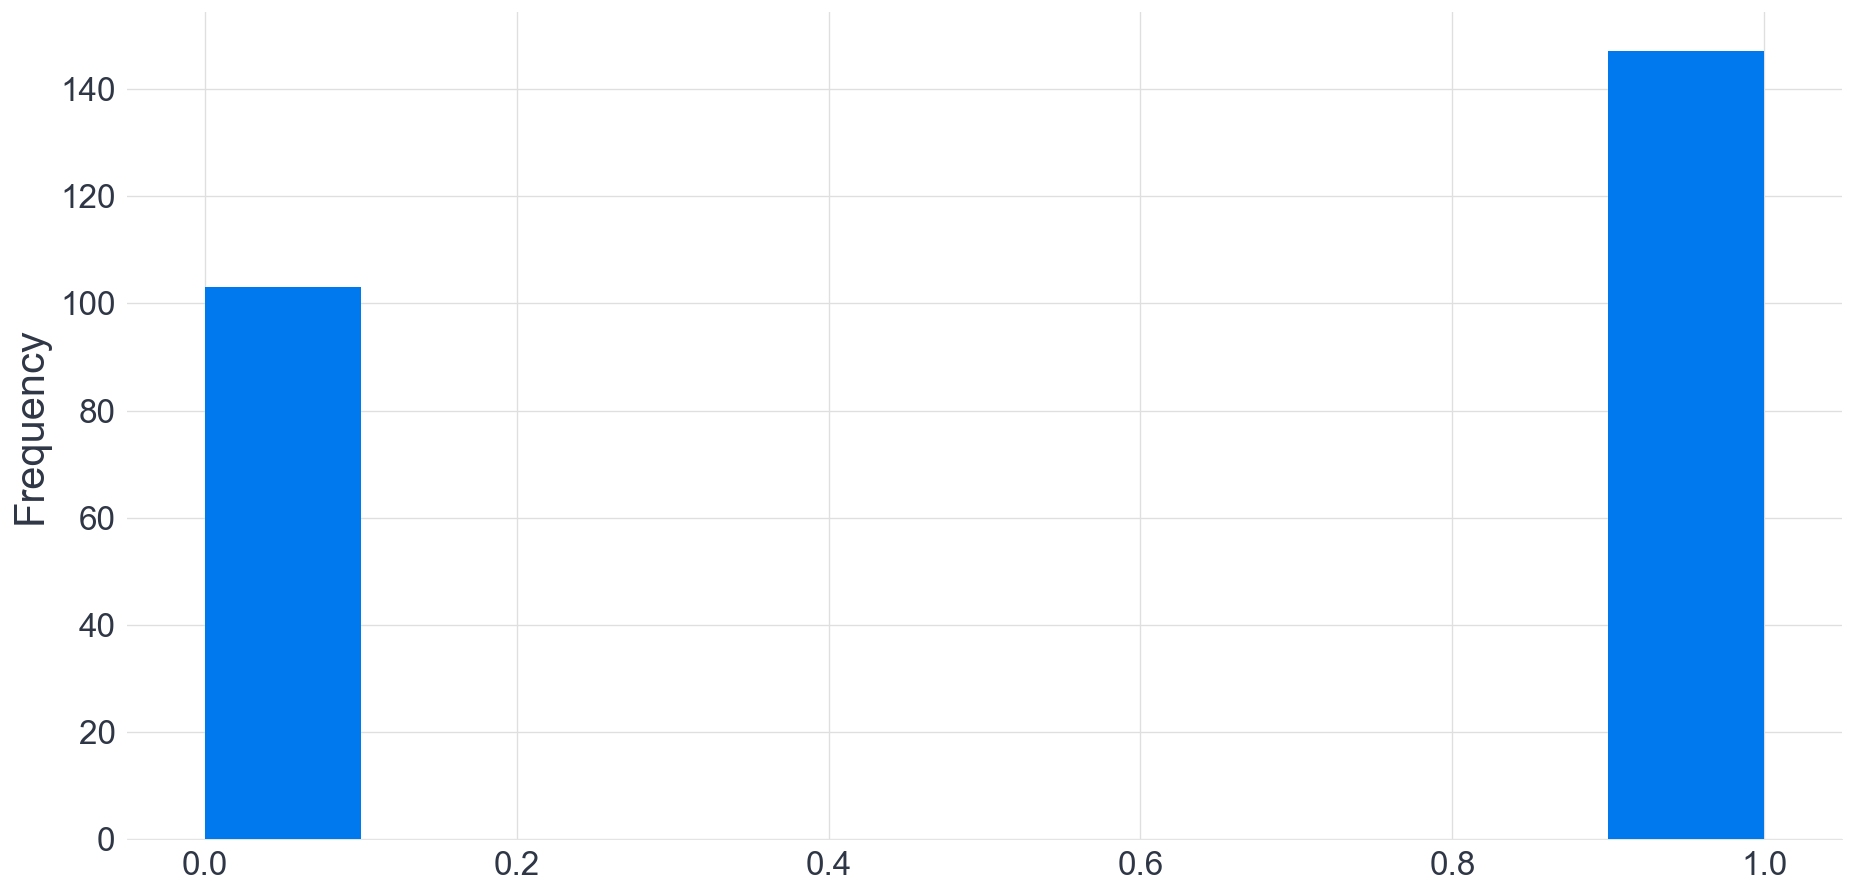

In [45]:
fish_data["camper"].astype(float).plot(kind="hist");

In [46]:
common_priors = {"common": bmb.Prior("Normal", mu=0, sigma=0.5)}

zip_fish_simple = bmb.Model(
    "count ~ 0 + camper + scale(persons) + child", 
    fish_data, 
    family='zero_inflated_poisson',
    priors=common_priors,
)
zip_fish_simple.build()
zip_fish_simple

       Formula: count ~ 0 + camper + scale(persons) + child
        Family: zero_inflated_poisson
          Link: mu = log
  Observations: 250
        Priors: 
    target = mu
        Common-level effects
            camper ~ Normal(mu: 0.0, sigma: 0.5)
            scale(persons) ~ Normal(mu: 0.0, sigma: 0.5)
            child ~ Normal(mu: 0.0, sigma: 0.5)
        
        Auxiliary parameters
            psi ~ Beta(alpha: 2.0, beta: 2.0)

In [47]:
zip_fish_simple_idata = zip_fish_simple.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, camper, scale(persons), child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [48]:
zip_fish_simple_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [49]:
az.summary(zip_fish_simple_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
camper[0.0],1.150,0.097,0.967,1.330,0.002,0.001,3633.0,3067.0,1.0
camper[1.0],1.968,0.060,1.858,2.079,0.001,0.001,2741.0,2860.0,1.0
scale(persons),0.982,0.051,0.888,1.076,0.001,0.001,2754.0,2475.0,1.0
child,-1.308,0.091,-1.489,-1.149,0.001,0.001,3703.0,3217.0,1.0
count_psi,0.591,0.044,0.508,0.671,0.001,0.001,3484.0,3232.0,1.0


## 3b: Write the same model in PyMC
Standardize the persons column (this time you can't use Bambi to do it, you have to do it yourself).


We've copied the Bambi model for you for reference:

```python
formula = bmb.Formula(
    "count ~ 0 + camper + persons + child", # Poisson rate, mu
    "psi ~ child"    # Probability of entering Poisson process, psi
)
common_priors = {
    "common": bmb.Prior("Normal", mu=0, sigma=0.5),
    "psi": {"common": bmb.Prior("Normal", mu=0, sigma=0.5)},
}

zip_fish_complex = bmb.Model(
    formula, 
    fish_data, 
    family='zero_inflated_poisson',
    priors=common_priors,
)
```

In [50]:
# Google easiest way to normalize python. This also needs some changes to model structure
persons_standardized = (fish_data["persons"] - fish_data["persons"].mean()) / fish_data["persons"].std()

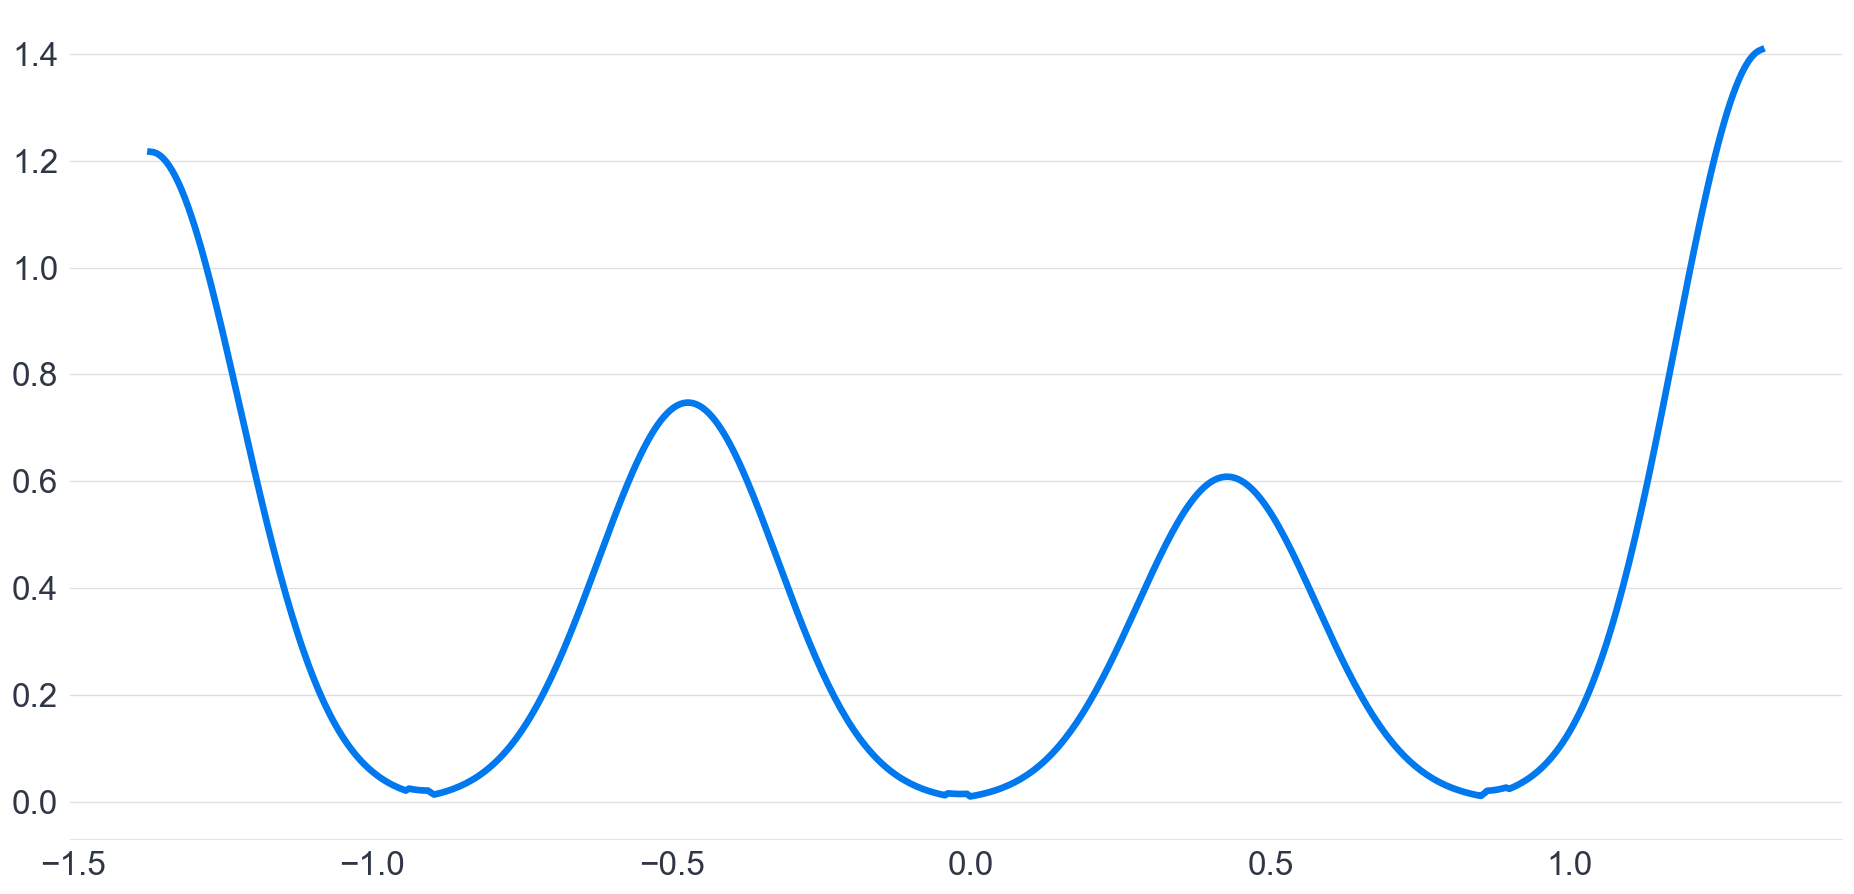

In [51]:
az.plot_dist(persons_standardized);

In [52]:
with pm.Model() as zip_fish_complex:
    # Data containers
    camper_idx = pm.MutableData("camper_idx", fish_data["camper"].astype(int).to_numpy())
    persons_data = pm.MutableData("persons_data", persons_standardized)
    child_data = pm.MutableData("child_data", fish_data["child"].to_numpy())
    
    ## Poisson model
    # Priors
    camper = pm.Normal("camper", 0, .5, shape=2)
    persons = pm.Normal("persons", 0, .5)
    child = pm.Normal("child", 0, .5)

    # Poisson rate
    μ = pm.Deterministic(
        "μ",
        pm.math.exp(camper[camper_idx] + persons * persons_data + child * child_data),
    )

    ## Zero-inflation process
    # Priors
    psi_intercept = pm.Normal("psi_intercept", 0, .5)
    psi_child = pm.Normal("psi_child", 0, .5)
    
    # Probability of entering Poisson process
    ψ = pm.Deterministic(
        "ψ",
        pm.math.sigmoid(psi_intercept + child_data * psi_child)
    )

    goals = pm.ZeroInflatedPoisson(
        "goals", psi=ψ, mu=μ, observed=fish_data["count"]
    )

    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [camper, persons, child, psi_intercept, psi_child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


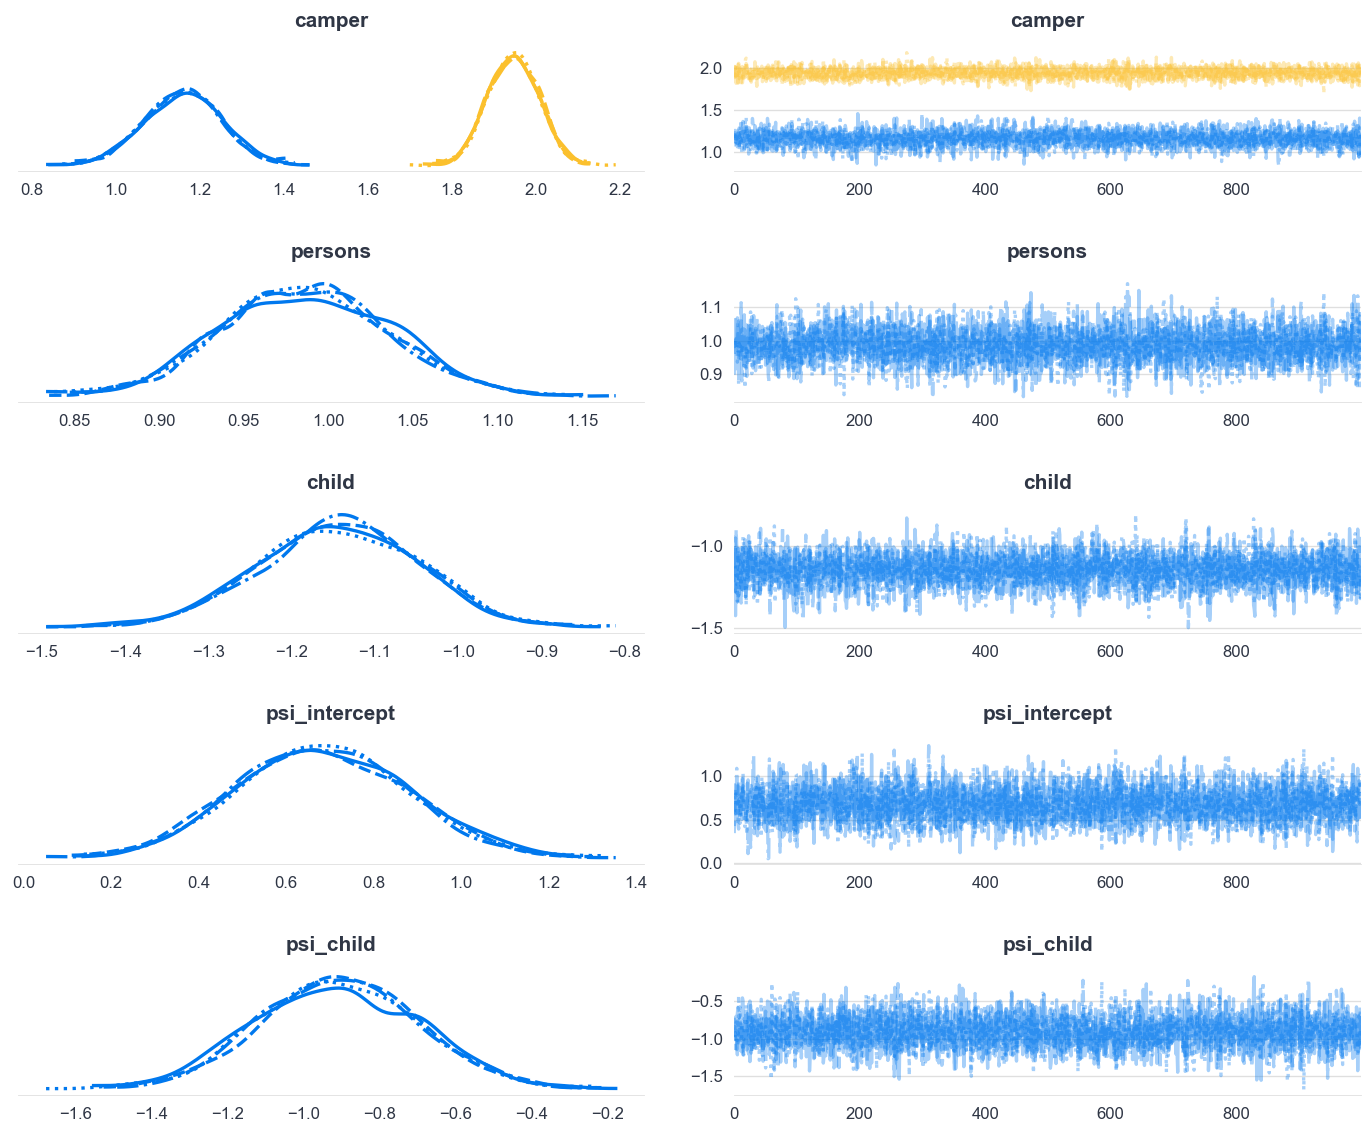

In [53]:
az.plot_trace(idata, var_names=["~μ", "~ψ"]);

In [54]:
az.summary(idata, var_names=["~μ", "~ψ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
camper[0],1.158,0.092,0.986,1.328,0.002,0.001,3589.0,3025.0,1.0
camper[1],1.946,0.060,1.831,2.052,0.001,0.001,3309.0,2942.0,1.0
persons,0.986,0.050,0.901,1.087,0.001,0.001,3553.0,2967.0,1.0
child,-1.144,0.096,-1.330,-0.976,0.001,0.001,4128.0,2810.0,1.0
psi_intercept,0.684,0.195,0.342,1.065,0.003,0.002,3631.0,3251.0,1.0
psi_child,-0.907,0.212,-1.289,-0.498,0.004,0.003,3465.0,3022.0,1.0


## 3c: Remake some plots!

Remake these plots using your PyMC model from the previous question and only use ArviZ or Matplotlib to recreate the graphs BAMBI gives you. To recreate the Bambi plots, we need to compute predictions conditional on the covariate of interest, while keeping the other covariates constant. The way Bambi does that under the hood, in the way we've asked it in the lesson, is to __keep covariates _not present_ in `conditional` at their mean (if numbers) or mode (if categories)__. 

For the covariate(s) we want to condition on, Bambi creates a grid of equally spaced values between the minimum and maximum values of the specified explanatory variable.

This exercise is a bit challenging, but it really forces you to think about the samples and how to summarsize them visually into something interesting. It'll also ensure you fully understand what is being plotted by Bambi.

In [55]:
# Replace values of covariates
counterfact_persons = np.linspace(persons_standardized.min(), persons_standardized.max())
m_persons = pm.do(
    zip_fish_complex, 
    {
        "camper_idx": np.full_like(counterfact_persons, fish_data["camper"].mode()[0], dtype="int32"),
        "persons_data": counterfact_persons,
        "child_data": np.full_like(counterfact_persons, fish_data["child"].mean()),
    }
)
# get predictions
with m_persons:
    preds_persons = pm.sample_posterior_predictive(idata, var_names=["μ"])

Sampling: []


In [56]:
counterfact_child = np.linspace(fish_data["child"].min(), fish_data["child"].max())
m_child = pm.do(
    zip_fish_complex,
    {
        "camper_idx": np.full_like(counterfact_child, fish_data["camper"].mode()[0], dtype="int32"),
        "persons_data": np.full_like(counterfact_child, persons_standardized.mean()),
        "child_data": counterfact_child,
    }
)

with m_child:
    preds_child = pm.sample_posterior_predictive(idata, var_names=["μ", "ψ"])

Sampling: []


In [57]:
m_camper = pm.do(
    zip_fish_complex, 
    {
        "camper_idx": [0, 1],
        "persons_data": [persons_standardized.mean(), persons_standardized.mean()],
        "child_data": [fish_data["child"].mean(), fish_data["child"].mean()],
    }
)

with m_camper:
    preds_camper = pm.sample_posterior_predictive(idata, var_names=["μ"])

Sampling: []


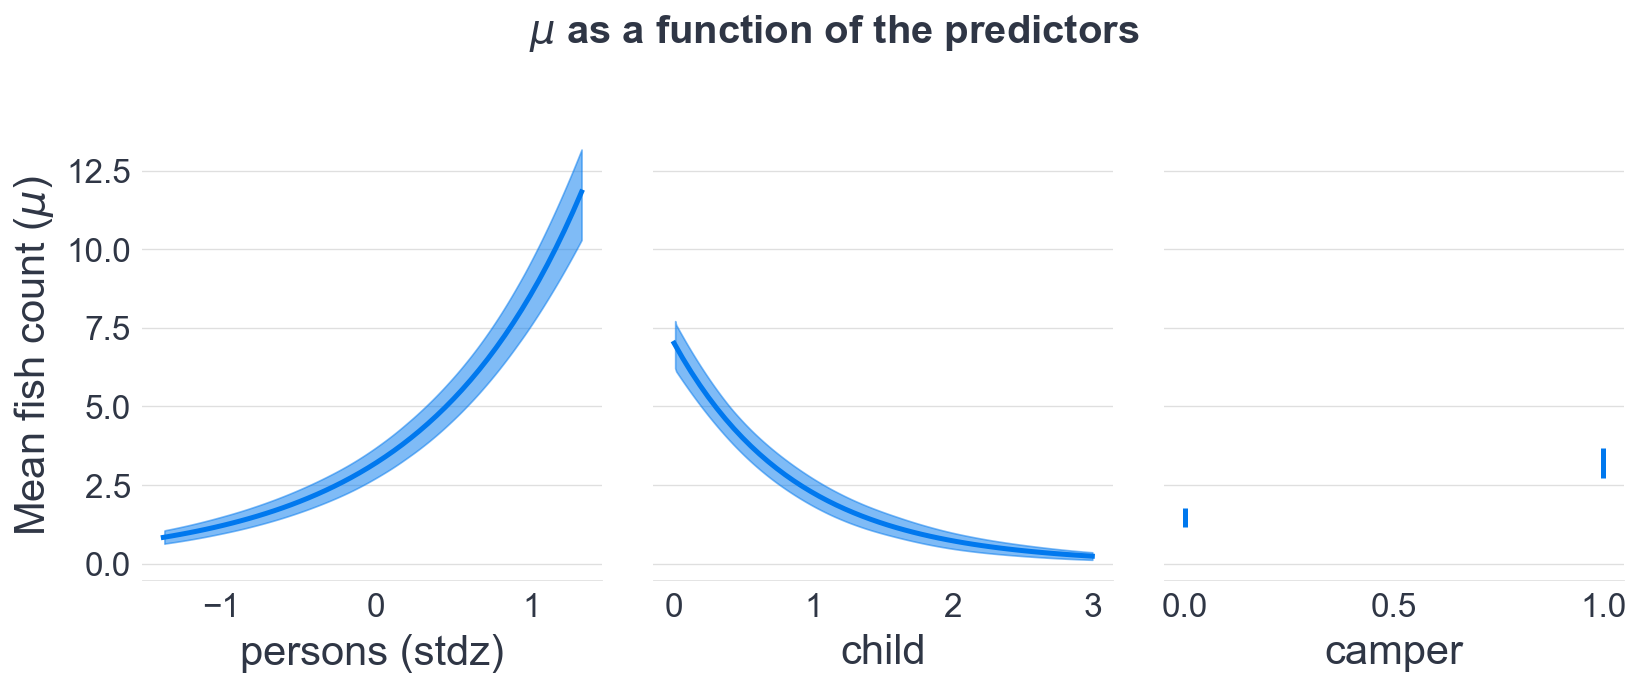

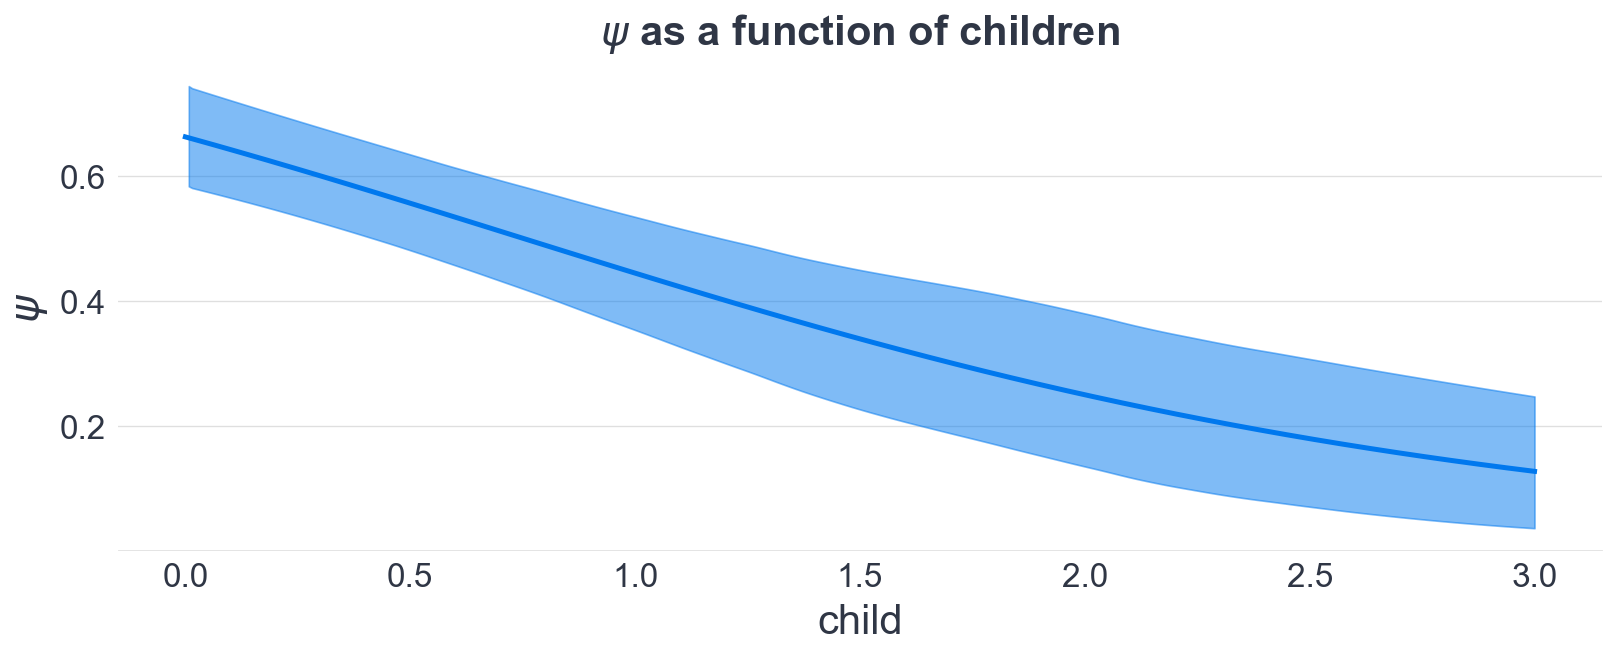

In [58]:
_, (left, mid, right) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

preds = preds_persons.posterior_predictive["μ"]
az.plot_hdi(counterfact_persons, preds, ax=left, color="C0")
left.plot(counterfact_persons, preds.mean(("chain", "draw")), lw="3", color="C0")
left.set(xlabel="persons (stdz)", ylabel="Mean fish count ($\mu$)")

preds = preds_child.posterior_predictive["μ"]
az.plot_hdi(counterfact_child, preds, ax=mid, color="C0")
mid.plot(counterfact_child, preds.mean(("chain", "draw")), lw="3", color="C0")
mid.set(xlabel="child", ylabel="")

hdi = az.hdi(preds_camper.posterior_predictive)["μ"]
right.vlines(
    [0, 1],
    hdi.sel(hdi="lower"),
    hdi.sel(hdi="higher"),
    lw=3,
    colors="C0",
)
right.set(xlabel="camper", ylabel="")
plt.suptitle("$\mu$ as a function of the predictors", fontsize=24)

_, ax = plt.subplots(1, 1, figsize=(14, 6))
preds = preds_child.posterior_predictive["ψ"]
az.plot_hdi(counterfact_child, preds, ax=ax, color="C0")
ax.plot(counterfact_child, preds.mean(("chain", "draw")), lw="3", color="C0")
ax.set(xlabel="child", ylabel="$\psi$", title="$\psi$ as a function of children");